In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import pandas as pd
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
import emcee
import corner
from scipy.optimize import minimize
from IPython.display import display, Math
import matplotlib as mpl
from multiprocessing.pool import Pool
from mcmc_functions import *
import pickle
import h5py
import glob
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

SAVE_DIR = './mcmc_fp_results/'

In [3]:
# read in the data (df created in fp jupyter notebook)
snztf18 = pd.read_csv('./mcmc_fp_results/subselected_dfs/snztf18.csv')
sn19rwd = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn19rwd.csv')
sn20ano = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn20ano.csv',)
sn20bio = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn20bio.csv')
sn20ikq = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn20ikq.csv',)
sn20rsc = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn20rsc.csv',)
# sn21aezx = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21aezx.csv')
sn21gno = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21gno.csv')
sn21heh = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21heh.csv')
# sn21pb = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21pb.csv')
sn21vgn = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21vgn.csv')
sn22hnt = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn22hnt.csv')
sn22jpx = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn22jpx.csv')
sn22qzr = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn22qzr.csv')
sn22qzr.columns

Index(['JD', 'filter', 'mag', 'ztf_mag_lower', 'ztf_mag_upper',
       'atlas_mag_err', 'data_origin', 'norm_t', 'norm_m', 'max_ztf_err',
       'mag_err_all'],
      dtype='object')

**ADD SN21PB TO REST OF THIS !!!**

In [4]:
df_str_list = ['snztf18','sn19rwd','sn20ano','sn20bio','sn20ikq','sn20rsc','sn21gno','sn21heh','sn21vgn','sn22hnt','sn22jpx','sn22qzr']
df_sub_ls = [snztf18,sn19rwd,sn20ano,sn20bio,sn20ikq,sn20rsc,sn21gno,sn21heh,sn21vgn,sn22hnt,sn22jpx,sn22qzr]
plot_names = ['ZTF18aalrxas', '19rwd', '20ano','20bio','20ikq','20rsc','21gno','21heh','21vgn','22hnt','22jpx','22qzr']

In [5]:
r1_bool_dict = {
        "g": {"snztf18":True,
              "sn19rwd":True,
              "sn20bio":True,
              "sn21gno":True,
              "sn21heh":True,
              "sn21vgn":True,
              'sn22hnt':False,
              'sn22jpx':False,
              'sn22qzr':False,
              'sn20ano':True,
              'sn20ikq':True,
              'sn20rsc':True,
              'sn21pb':False},
        "r": {"snztf18":True,
              "sn19rwd":True,
              "sn20bio":True,
              "sn21gno":True,
              "sn21heh":True,
              "sn21vgn":True,
              'sn22hnt':True,
              'sn22jpx':True,
              'sn22qzr':True,
              'sn20ano':True,
              'sn20ikq':True,
              'sn20rsc':True,
              'sn21pb':True}
    }

In [6]:
# if code crashes, reload the chains here to find bestfit
g_chains = []
r_chains = []
for i in range(len(df_str_list)):
    save_dir = './mcmc_fp_results/flatchains/'
    gf = save_dir+df_str_list[i]+'_g_flatchains.txt'
    rf = save_dir+df_str_list[i]+'_r_flatchains.txt'
    g_chains.append(gf)
    r_chains.append(rf)

def bestfit_recovery(filename, sub_df, band='', r1_bool=True, sn_id_band='test_g', replot=False):
    flat_samples = np.loadtxt(filename)
    if r1_bool:
        ndim = 7
    if not r1_bool:
        ndim = 5

    mcmc_results = []
    #retrieve the 16th/50th/84th percentile for each param and the lower/upper bounds on each
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        arr = [mcmc[1], q[0], q[1]]
        mcmc_results.append(arr)

    # making fit/autocorr/corner plots
    if band == 'g':
        g_df = sub_df[(sub_df['filter']=='ZTF_g') | (sub_df['filter']=='c')]
        x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
    if band == 'r':
        r_df = sub_df[(sub_df['filter']=='ZTF_r') | (sub_df['filter']=='o')]
        x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
    if replot:
        plot_mcmc_results(x, y, yerr, mcmc_results, flat_samples, r1=r1_bool, sn_band=sn_id_band, save=True)
        do_gw_autocorr_and_plot(filename, sn_id_band)

    return mcmc_results#,flat_samples

In [7]:
all_fits_g = [] # shape (13, 7, 3) (nobjects, nparams, npercentiles)
for i,file in enumerate(g_chains):
    fit = bestfit_recovery(file, df_sub_ls[i], band='g', r1_bool=r1_bool_dict['g'][df_str_list[i]],sn_id_band=df_str_list[i]+'_g')
    all_fits_g.append(fit)

In [8]:
all_fits_r = [] # shape (13, 7, 3) (nobjects, nparams, npercentiles)
for i,file in enumerate(r_chains):
    fit = bestfit_recovery(file, df_sub_ls[i], band='r', r1_bool=r1_bool_dict['r'][df_str_list[i]],sn_id_band=df_str_list[i]+'_r')
    all_fits_r.append(fit)

In [9]:
with open(SAVE_DIR+'bestfits_g.npy', 'wb') as f:
    np.save(f, np.array(all_fits_g))

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_86128/3630745897.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f, np.array(all_fits_g))


In [10]:
with open(SAVE_DIR+'bestfits_r.npy', 'wb') as f:
    np.save(f, np.array(all_fits_r))

In [11]:
#the next two loops separate out the indivudal param values and append to list to do stats on them
best_fits_g,best_fits_r = [],[]
low_err_g, upp_err_g =[],[]
low_err_r, upp_err_r =[],[]
for i in range(len(all_fits_r)):
    #g band
    bestg = np.array(all_fits_g[i]).T[0]  #bestfit (50% ptile) values
    lowg = np.array(all_fits_g[i]).T[1]   #lower bound, 16% ptile
    highg =  np.array(all_fits_g[i]).T[2] #upper bound, 84% ptile
    best_fits_g.append(bestg)
    low_err_g.append(lowg)
    upp_err_g.append(highg)

    #r band
    bestr = np.array(all_fits_r[i]).T[0]  #bestfit (50% ptile) values
    lowr = np.array(all_fits_r[i]).T[1]   #lower bound, 16% ptile
    highr =  np.array(all_fits_r[i]).T[2] #upper bound, 84% ptile
    best_fits_r.append(bestr)
    low_err_r.append(lowr)
    upp_err_r.append(highr)

# formatting and saving best fits values in g and r
best_fits_g_same_len = []
for i,arr in enumerate(best_fits_g):
    if len(arr) == 5:
        arr = np.insert(arr, [0,3], np.nan)
    best_fits_g_same_len.append(arr)

best_fits_r_same_len = []
for i,arr in enumerate(best_fits_r):
    if len(arr) == 5:
        arr = np.insert(arr, [0,3], np.nan)
    best_fits_r_same_len.append(arr)

#saving to df
best_fits_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
best_fits_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
bestfit_df = pd.DataFrame(columns=best_fits_cols_g, data=best_fits_g_same_len)
bestfit_r_df = pd.DataFrame(columns=best_fits_cols_r, data=best_fits_r_same_len)
bestfit_df.insert(0,'SN_ID', df_str_list)
bestfit_df = pd.concat([bestfit_df,bestfit_r_df], axis=1)
bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,m3_r,b2_r,a1_r,a2_r,log_f_r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,-0.073302,-2.350598,7.663041,15.613060,-3.564006
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,-0.029224,-1.386172,8.728792,13.820153,-1.902896
2,sn20ano,-0.606980,0.382998,-0.088906,-5.203419,9.180605,14.371975,-0.533924,-0.715000,0.299137,-0.084340,-4.335608,8.722938,13.916714,-3.500523
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,-0.133987,-3.897599,9.193014,16.188675,-3.466265
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,-0.003679,-0.828949,1.582649,15.622305,-1.472611
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,-0.062612,-3.515344,10.101722,16.254400,0.209470
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,-0.105575,-1.871648,10.381562,13.481051,-2.602094
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,-0.059142,-2.657557,4.501014,13.922081,-2.373261
8,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,-0.059288,-2.048997,7.264507,13.407664,-0.335258
9,sn22hnt,NaN,0.351776,-0.140359,-4.595594,NaN,14.062884,-1.598560,-0.876070,0.301263,-0.122269,-4.282895,9.226942,13.391593,-2.614484


In [12]:
#same sn, same lc, same filters, diff params
bestfit_df['a2g-a1g'] = bestfit_df['a2_g'] - bestfit_df['a1_g']
bestfit_df['a2r-a1r'] = bestfit_df['a2_r'] - bestfit_df['a1_r']
#same sn, diff lc, diff filters, same params
bestfit_df['a1g-a1r'] = bestfit_df['a1_g'] - bestfit_df['a1_r']
bestfit_df['a2g-a2r'] = bestfit_df['a2_g'] - bestfit_df['a2_r']
bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,m3_r,b2_r,a1_r,a2_r,log_f_r,a2g-a1g,a2r-a1r,a1g-a1r,a2g-a2r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,-0.073302,-2.350598,7.663041,15.613060,-3.564006,6.393828,7.950019,-0.948900,-2.505090
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,-0.029224,-1.386172,8.728792,13.820153,-1.902896,5.902160,5.091361,-0.466980,0.343819
2,sn20ano,-0.606980,0.382998,-0.088906,-5.203419,9.180605,14.371975,-0.533924,-0.715000,0.299137,-0.084340,-4.335608,8.722938,13.916714,-3.500523,5.191370,5.193776,0.457667,0.455261
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,-0.133987,-3.897599,9.193014,16.188675,-3.466265,5.307184,6.995661,0.217111,-1.471366
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,-0.003679,-0.828949,1.582649,15.622305,-1.472611,12.399674,14.039656,0.659082,-0.980899
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,-0.062612,-3.515344,10.101722,16.254400,0.209470,7.535430,6.152678,-0.030420,1.352333
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,-0.105575,-1.871648,10.381562,13.481051,-2.602094,4.131018,3.099489,-0.583495,0.448034
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,-0.059142,-2.657557,4.501014,13.922081,-2.373261,12.291356,9.421067,-1.806982,1.063307
8,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,-0.059288,-2.048997,7.264507,13.407664,-0.335258,6.290702,6.143158,-0.027992,0.119553
9,sn22hnt,NaN,0.351776,-0.140359,-4.595594,NaN,14.062884,-1.598560,-0.876070,0.301263,-0.122269,-4.282895,9.226942,13.391593,-2.614484,NaN,4.164651,NaN,0.671290


In [13]:
#finding the model mag at bestfit: a1/a2 for each band

m_a2g_a1g_ls, m_a2r_a1r_ls, m_a1g_a1r_ls, m_a2g_a2r_ls = [],[],[],[]
for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]

    #gband
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    x_plt_g = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)
    sn_g = bestfit_df.loc[:,bestfit_df.columns.str[-2:]=='_g'].loc[i]
    sn_g = sn_g.loc[sn_g.notna()].to_numpy()
    a1_g, a2_g = bestfit_df['a1_g'].loc[i], bestfit_df['a2_g'].loc[i]
    a1crit_g = np.abs(x_plt_g - a1_g).argmin()
    a2crit_g = np.abs(x_plt_g - a2_g).argmin()

    mags_g = np.array([model(sn_g, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt_g])
    a1_gmag = mags_g[a1crit_g] 
    a2_gmag = mags_g[a2crit_g]

    #rband
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
    x_plt_r = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)
    sn_r = bestfit_df.loc[:,bestfit_df.columns.str[-2:]=='_r'].loc[i]
    sn_r = sn_r.loc[sn_r.notna()].to_numpy()
    a1_r, a2_r = bestfit_df['a1_r'].loc[i], bestfit_df['a2_r'].loc[i]
    a1crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a1_r).argmin()]
    a2crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a2_r).argmin()]
    
    mags_r = np.array([model(sn_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt_r])
    a1_rmag = mags_r[a1crit_r]
    a2_rmag = mags_r[a2crit_r]

    #calcing quants
    m_a2g_a1g = a2_gmag - a1_gmag
    m_a2r_a1r = a2_rmag - a1_rmag
    m_a1g_a1r = a1_gmag - a1_rmag
    m_a2g_a2r = a2_gmag - a2_rmag

    #appending
    m_a2g_a1g_ls.append(m_a2g_a1g)
    m_a2r_a1r_ls.append(m_a2r_a1r[0])
    m_a1g_a1r_ls.append(m_a1g_a1r[0])
    m_a2g_a2r_ls.append(m_a2g_a2r[0])

bestfit_df['mag_a2g-a1g'] = m_a2g_a1g_ls
bestfit_df['mag_a2r-a1r'] = m_a2r_a1r_ls
bestfit_df['mag_a1g-a1r'] = m_a1g_a1r_ls
bestfit_df['mag_a2g-a2r'] = m_a2g_a2r_ls

bestfit_df.to_csv(SAVE_DIR+'/mcmc_bestfit_vals.csv')

bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,...,a2_r,log_f_r,a2g-a1g,a2r-a1r,a1g-a1r,a2g-a2r,mag_a2g-a1g,mag_a2r-a1r,mag_a1g-a1r,mag_a2g-a2r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,...,15.613060,-3.564006,6.393828,7.950019,-0.948900,-2.505090,1.716062,0.917334,-0.598606,0.200123
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,...,13.820153,-1.902896,5.902160,5.091361,-0.466980,0.343819,0.835932,0.463921,-0.152970,0.219041
2,sn20ano,-0.606980,0.382998,-0.088906,-5.203419,9.180605,14.371975,-0.533924,-0.715000,0.299137,...,13.916714,-3.500523,5.191370,5.193776,0.457667,0.455261,1.987588,1.552494,0.038507,0.473601
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,...,16.188675,-3.466265,5.307184,6.995661,0.217111,-1.471366,0.992863,1.976614,0.480072,-0.503679
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,...,15.622305,-1.472611,12.399674,14.039656,0.659082,-0.980899,1.332726,0.487833,-0.630919,0.213974
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,...,16.254400,0.209470,7.535430,6.152678,-0.030420,1.352333,2.747805,1.494123,-0.333023,0.920660
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,...,13.481051,-2.602094,4.131018,3.099489,-0.583495,0.448034,0.627611,0.368723,-0.000500,0.258387
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,...,13.922081,-2.373261,12.291356,9.421067,-1.806982,1.063307,2.026297,1.296023,-0.123179,0.607096
8,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,...,13.407664,-0.335258,6.290702,6.143158,-0.027992,0.119553,1.296530,1.020132,-0.040556,0.235842
9,sn22hnt,NaN,0.351776,-0.140359,-4.595594,NaN,14.062884,-1.598560,-0.876070,0.301263,...,13.391593,-2.614484,NaN,4.164651,NaN,0.671290,1.776468,1.253316,0.076619,0.599771


In [14]:
# MCMC FIT STATS
# best fit goes in order of: m1,m2,m3,b2,a1,a2,logf
def comp_stats(values,val=''):
    minv = min(values)
    p25 = np.percentile(values, 25)
    p50 = np.percentile(values, 50)
    mean = np.mean(values)
    p75 = np.percentile(values, 75)
    maxv = max(values)
    std = np.std(values)
    # print('\033[1m'+val+': min,  25%,  med,  mean,  75%,  max,  std \033[0m \n', 
    #       round(minv,3),round(p25,3),round(p50,3),round(mean,3),round(p75,3),round(maxv,3,),round(std,3))#,'\n')
    return np.array([minv,p25,p50,mean,p75,maxv,std])

#computing the stats
stats_g, stats_r, stats_other = [],[],[]
for i in range(len(bestfit_df.columns[1:])):
    col = bestfit_df.columns[1:][i]
    if col[-2:] == '_g':
        g = comp_stats(bestfit_df[col],val=col)
        stats_g.append(g)
    elif col[-2:] == '_r':
        r = comp_stats(bestfit_df[col],val=col)
        stats_r.append(r)
    else: 
        o = comp_stats(bestfit_df[col],val=col)
        stats_other.append(o)
    
#saving to df 
stats_col = ['min','p25','med','mean','p75','max','std']
stats_df = pd.DataFrame(columns=stats_col, data=stats_g)
stats_df_r = pd.DataFrame(columns=stats_col, data=stats_r)
stats_df_other = pd.DataFrame(columns=stats_col, data=stats_other)
stats_df = pd.concat([stats_df,stats_df_r],ignore_index=True)
stats_df= pd.concat([stats_df,stats_df_other],ignore_index=True)
stats_df.insert(0, 'param', ['m1', 'm2', 'm3', 'b2', 'a1', 'a2', 'log_f']*2 + list(bestfit_df.columns[15:]))
stats_df['filter'] = ['g']*len(stats_g) + ['r']*len(stats_r) + ['both']*len(bestfit_df.columns[15:])
stats_df.to_csv(SAVE_DIR+'/mcmc_bestfit_stats.csv')
stats_df[['param','min','mean','max','std']]

,param,min,mean,max,std
0,m1,-1.589472,-1.092759,-0.606980,0.343090
1,m2,0.107934,0.228161,0.382998,0.090125
2,m3,-0.183369,-0.081053,-0.003755,0.051902
3,b2,-5.203419,-3.154719,-1.651887,1.241998
4,a1,2.241731,7.289814,10.071302,2.788512
5,a2,12.558127,14.387925,17.606733,1.202028
6,log_f,-3.746322,-1.431674,1.364686,1.292678
7,m1,-1.653940,-0.980610,-0.433238,0.363202
8,m2,0.034754,0.186147,0.343726,0.097958
9,m3,-0.141956,-0.076213,-0.003679,0.041152


In [15]:
# colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a']
colors = ['#8dd3c7','#ff7f00','#bebada','#80b1d3','#fdb462','#b3de69','#fccde5','#6a3d9a','#bc80bd','#ccebc5','#ffed6f', '#fb8072']

[6.714141013928119, 8.261811821051513, 9.180604768067962, 9.410124652588069, 2.2417309009843183, 10.071302300202417, 9.798066566794084, 2.6940319952994747, 7.23651461621449, -4.595593968600115, -1.969395938122245, -3.904050154510529]
6.975327815071305 4.594940714491464 12 6.126587619321951


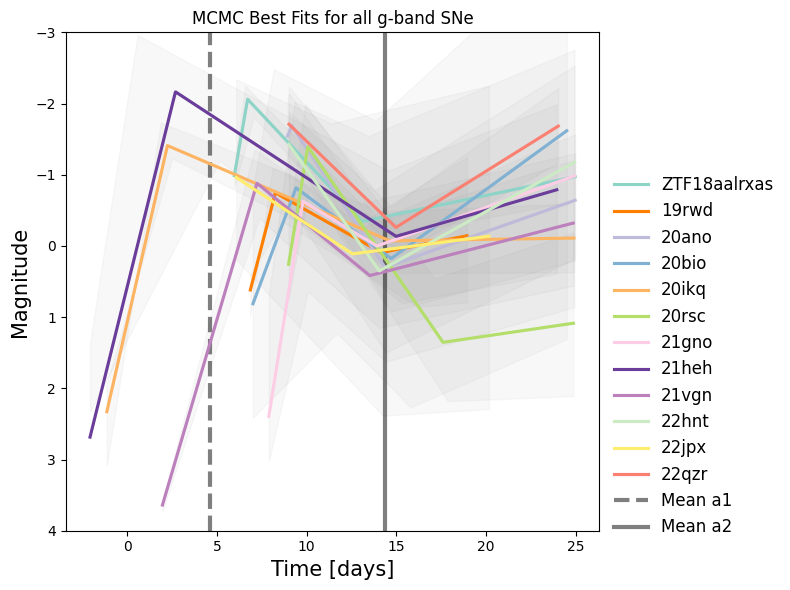

In [413]:
a1s,a2s = [],[]
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

    best = np.array(all_fits_g[i]).T[0] #bestfit values
    lower_bound = np.array(all_fits_g[i]).T[0] - np.array(all_fits_g[i]).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(all_fits_g[i]).T[0] + np.array(all_fits_g[i]).T[2] #50th ptile + diff_84ptile
    a1s.append(best[-3])
    a2s.append(best[-2])
    
    #plotting mcmc results
    plt.plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], alpha=1.0, linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    plt.fill_between(x_plt, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)
    
    # #plotting ztf/atlas data
    x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
    # plt.errorbar(x, y, yerr, linestyle='', marker='.', color='black', alpha=0.075, label='data', markersize=15) #ztf errors
print(a1s)
print(np.median(a1s),np.mean(a1s), len(a1s), sum(a1s)/9)
min_a1, med_a1, max_a1 = min(a1s), np.mean(a1s), max(a1s)
min_a2, med_a2, max_a2 = min(a2s), np.mean(a2s), max(a2s)
# plt.axvspan(min_a1, max_a1, alpha=0.03, facecolor='gray', label='a1_range', edgecolor='black', hatch='/', zorder=0)
# plt.axvspan(min_a2, max_a2, alpha=0.03, facecolor='gray', label='a2_range', edgecolor='black', hatch='-', zorder=0)
plt.axvline(med_a1,alpha=0.5, color='black', linestyle='dashed', linewidth=3, label='Mean a1', zorder=1)
plt.axvline(med_a2,alpha=0.5, color='black', linestyle='solid', linewidth=3, label='Mean a2', zorder=1)

handles, labels = ax.get_legend_handles_labels()

plt.xlabel('Time [days]',fontsize=15)
plt.ylabel('Magnitude',fontsize=15)
plt.title('MCMC Best Fits for all g-band SNe')
plt.ylim(4,-3)
ax.legend(handles, labels[0:15], loc='center left', bbox_to_anchor=(1, 0.35),frameon=False, fontsize=12)

plt.tight_layout()
# plt.savefig(SAVE_DIR+'/figures/all_mcmc_fits_g_a12err.png')
plt.savefig(SAVE_DIR+'/figures/all_mcmc_fits_g_errband.png')

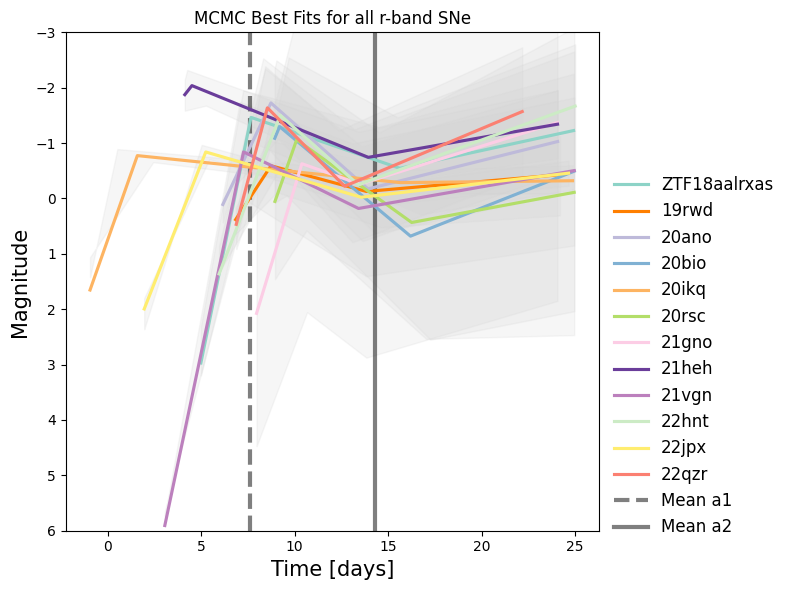

In [406]:
# x_plt = np.arange(1,40,0.01)
# colors=['red', 'darkorange', 'gold', 'green', 'blue', 'purple']
# ls = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3)), (0, (3, 5, 1, 5))]

a1s,a2s = [],[]
plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
    x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

    best = np.array(all_fits_r[i]).T[0] #bestfit values
    lower_bound = np.array(all_fits_r[i]).T[0] - np.array(all_fits_r[i]).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(all_fits_r[i]).T[0] + np.array(all_fits_r[i]).T[2] #50th ptile + diff_84ptile
    a1s.append(best[-3])
    a2s.append(best[-2])
    
    #plotting mcmc results
    plt.plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], alpha=1.0, linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    plt.fill_between(x_plt, lower_curve, upper_curve, color='lightgray', alpha=0.2, zorder=0)

    #plotting ztf data
    x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
    # plt.errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.05, label='data', markersize=15) #ztf errors, 

min_a1, med_a1, max_a1 = min(a1s), np.mean(a1s), max(a1s)
min_a2, med_a2, max_a2 = min(a2s), np.mean(a2s), max(a2s)
# plt.axvspan(min_a1, max_a1, alpha=0.05, facecolor='gray', label='a1_range', edgecolor='black', hatch='/', zorder=0)
# plt.axvspan(min_a2, max_a2, alpha=0.05, facecolor='gray', label='a2_range', edgecolor='black', hatch='-', zorder=0)
plt.axvline(med_a1,alpha=0.5, color='black', linestyle='dashed', linewidth=3, label='Mean a1', zorder=1)
plt.axvline(med_a2,alpha=0.5, color='black', linestyle='solid', linewidth=3, label='Mean a2', zorder=1)

plt.xlabel('Time [days]', fontsize=15)
plt.ylabel('Magnitude', fontsize=15)
plt.title('MCMC Best Fits for all r-band SNe')
plt.ylim(6,-3)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels[0:15], loc='center left', bbox_to_anchor=(1, 0.35),frameon=False, fontsize=12)
plt.tight_layout()
# plt.savefig(SAVE_DIR+'/figures/all_mcmc_fits_r_a12err.png')
plt.savefig(SAVE_DIR+'/figures/all_mcmc_fits_r_errband.png')

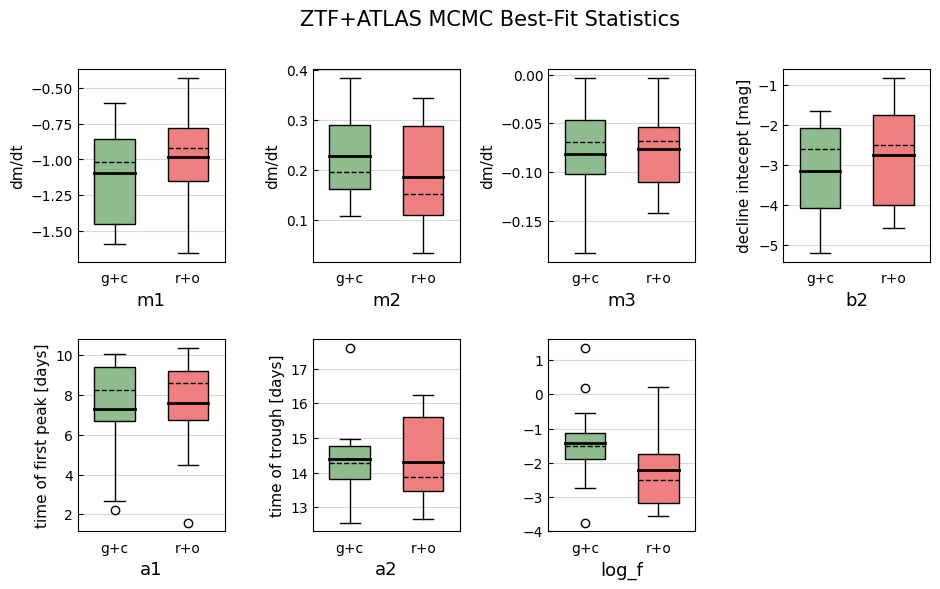

In [308]:
#making box and whisker plots and histograms
xlabels = ['m1', 'm2', 'm3', 'b2', 'a1', 'a2', 'log_f']
ylabels= ['dm/dt','dm/dt','dm/dt','decline intecept [mag]','time of first peak [days]', 'time of trough [days]']
labels = ['g+c','r+o']
boxprops = dict(linewidth=1.0, color='black')
medianprops = dict(linewidth=1.0, color='black', linestyle='--')
meanprops = dict(linewidth=2.0, color='black', linestyle='-')

def box_plot(data, loc=[0,0], label=labels, xlabel=xlabels):
    x1,x2 = loc[0],loc[1]
    bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
    colors = ['darkseagreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)  
    return bp

fig,axs = plt.subplots(2,4,figsize=(11,6))

box_plot([bestfit_df['m1_g'][bestfit_df['m1_g'].notna()],bestfit_df['m1_r'][bestfit_df['m1_r'].notna()]]
         ,loc=[0,0],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['m2_g'][bestfit_df['m2_g'].notna()],bestfit_df['m2_r'][bestfit_df['m2_r'].notna()]]
         ,loc=[0,1],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['m3_g'][bestfit_df['m3_g'].notna()],bestfit_df['m3_r'][bestfit_df['m3_r'].notna()]]
         ,loc=[0,2],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['b2_g'][bestfit_df['b2_g'].notna()],bestfit_df['b2_r'][bestfit_df['b2_r'].notna()]]
         ,loc=[0,3],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['a1_g'][bestfit_df['a1_g'].notna()],bestfit_df['a1_r'][bestfit_df['a1_r'].notna()]]
         ,loc=[1,0],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['a2_g'][bestfit_df['a2_g'].notna()],bestfit_df['a2_r'][bestfit_df['a2_r'].notna()]]
         ,loc=[1,1],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['log_f_g'][bestfit_df['log_f_g'].notna()],bestfit_df['log_f_r'][bestfit_df['log_f_r'].notna()]]
         ,loc=[1,2],label=labels,xlabel=xlabels[0])
axs[1,3].axis("off")

axs[0,0].set_xlabel(xlabels[0],fontsize=13)
axs[0,1].set_xlabel(xlabels[1],fontsize=13)
axs[0,2].set_xlabel(xlabels[2],fontsize=13)
axs[0,3].set_xlabel(xlabels[3],fontsize=13)
axs[1,0].set_xlabel(xlabels[4],fontsize=13)
axs[1,1].set_xlabel(xlabels[5],fontsize=13)
axs[1,2].set_xlabel(xlabels[6],fontsize=13)

axs[0,0].set_ylabel(ylabels[0],fontsize=11)
axs[0,1].set_ylabel(ylabels[1],fontsize=11)
axs[0,2].set_ylabel(ylabels[2],fontsize=11)
axs[0,3].set_ylabel(ylabels[3],fontsize=11)
axs[1,0].set_ylabel(ylabels[4],fontsize=11)
axs[1,1].set_ylabel(ylabels[5],fontsize=11)

axs[0,0].tick_params(axis="y",direction="in")
axs[0,0].tick_params(axis="x",top=False,bottom=False)
axs[0,0].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,1].tick_params(axis="y",direction="in")
axs[0,1].tick_params(axis="x",top=False,bottom=False)
axs[0,1].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,2].tick_params(axis="y",direction="in")
axs[0,2].tick_params(axis="x",top=False,bottom=False)
axs[0,2].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,3].tick_params(axis="y",direction="in")
axs[0,3].tick_params(axis="x",top=False,bottom=False)
axs[0,3].yaxis.grid(color='gray',alpha=0.3, linestyle='-')

axs[1,0].tick_params(axis="y",direction="in")
axs[1,0].tick_params(axis="x",top=False,bottom=False)
axs[1,0].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[1,1].tick_params(axis="y",direction="in")
axs[1,1].tick_params(axis="x",top=False,bottom=False)
axs[1,1].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[1,2].tick_params(axis="y",direction="in")
axs[1,2].tick_params(axis="x",top=False,bottom=False)
axs[1,2].yaxis.grid(color='gray',alpha=0.3, linestyle='-')


fig.subplots_adjust(hspace=0.4,wspace=0.6)
fig.suptitle('ZTF+ATLAS MCMC Best-Fit Statistics', fontsize=15)
plt.savefig(SAVE_DIR+'figures/boxwhisk_params.png',dpi=300)

KeyError: 'mag_a2g-a1g'

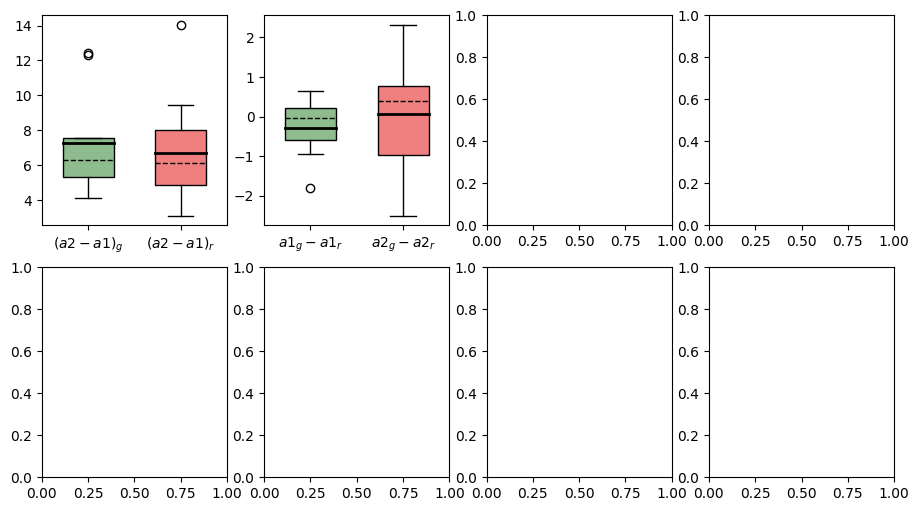

In [272]:
#making box and whisker plots and histograms
xlabels = ['time offsets', 'filter offsets', '$\Delta\mathrm{mag}(a2-a1)$', 'b2', 'a1', 'a2', 'log_f']
ylabels= ['[days]','[days]','Magnitude','decline intecept [mag]','time of first peak [days]', 'time of trough [days]']
labels = ['g+c','r+o']
boxprops = dict(linewidth=1.0, color='black')
medianprops = dict(linewidth=1.0, color='black', linestyle='--')
meanprops = dict(linewidth=2.0, color='black', linestyle='-')

def box_plot(data, loc=[0,0], label=labels, xlabel=xlabels):
    x1,x2 = loc[0],loc[1]
    bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
    colors = ['darkseagreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)  
    return bp

fig,axs = plt.subplots(2,4,figsize=(11,6))

box_plot([bestfit_df['a2g-a1g'][bestfit_df['a2g-a1g'].notna()],bestfit_df['a2r-a1r'][bestfit_df['a2r-a1r'].notna()]]
         ,loc=[0,0],label=['$(a2-a1)_g$','$(a2-a1)_r$'],xlabel=xlabels[0])
box_plot([bestfit_df['a1g-a1r'][bestfit_df['a1g-a1r'].notna()],bestfit_df['a2g-a2r'][bestfit_df['a2g-a2r'].notna()]]
         ,loc=[0,1],label=['$a1_g-a1_r$','$a2_g-a2_r$'],xlabel=xlabels[0])
box_plot([bestfit_df['mag_a2g-a1g'][bestfit_df['mag_a2g-a1g'].notna()],bestfit_df['mag_a2r-a1r'][bestfit_df['mag_a2r-a1r'].notna()]]
         ,loc=[0,2],label=labels,xlabel=[])
# box_plot([bestfit_df['b2_g'][bestfit_df['b2_g'].notna()],bestfit_df['b2_r'][bestfit_df['b2_r'].notna()]]
#          ,loc=[0,3],label=labels,xlabel=xlabels[0])
# box_plot([bestfit_df['a1_g'][bestfit_df['a1_g'].notna()],bestfit_df['a1_r'][bestfit_df['a1_r'].notna()]]
#          ,loc=[1,0],label=labels,xlabel=xlabels[0])
# box_plot([bestfit_df['a2_g'][bestfit_df['a2_g'].notna()],bestfit_df['a2_r'][bestfit_df['a2_r'].notna()]]
#          ,loc=[1,1],label=labels,xlabel=xlabels[0])
# box_plot([bestfit_df['log_f_g'][bestfit_df['log_f_g'].notna()],bestfit_df['log_f_r'][bestfit_df['log_f_r'].notna()]]
#          ,loc=[1,2],label=labels,xlabel=xlabels[0])
# axs[1,3].axis("off")

axs[0,0].set_xlabel(xlabels[0],fontsize=13)
axs[0,1].set_xlabel(xlabels[1],fontsize=13)
axs[0,2].set_xlabel(xlabels[2],fontsize=13)
axs[0,3].set_xlabel(xlabels[3],fontsize=13)
axs[1,0].set_xlabel(xlabels[4],fontsize=13)
axs[1,1].set_xlabel(xlabels[5],fontsize=13)
axs[1,2].set_xlabel(xlabels[6],fontsize=13)

axs[0,0].set_ylabel(ylabels[0],fontsize=11)
axs[0,1].set_ylabel(ylabels[1],fontsize=11)
axs[0,2].set_ylabel(ylabels[2],fontsize=11)
axs[0,3].set_ylabel(ylabels[3],fontsize=11)
axs[1,0].set_ylabel(ylabels[4],fontsize=11)
axs[1,1].set_ylabel(ylabels[5],fontsize=11)

axs[0,0].tick_params(axis="y",direction="in")
axs[0,0].tick_params(axis="x",top=False,bottom=False)
axs[0,0].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,1].tick_params(axis="y",direction="in")
axs[0,1].tick_params(axis="x",top=False,bottom=False)
axs[0,1].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,2].tick_params(axis="y",direction="in")
axs[0,2].tick_params(axis="x",top=False,bottom=False)
axs[0,2].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,3].tick_params(axis="y",direction="in")
axs[0,3].tick_params(axis="x",top=False,bottom=False)
axs[0,3].yaxis.grid(color='gray',alpha=0.3, linestyle='-')

axs[1,0].tick_params(axis="y",direction="in")
axs[1,0].tick_params(axis="x",top=False,bottom=False)
axs[1,0].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[1,1].tick_params(axis="y",direction="in")
axs[1,1].tick_params(axis="x",top=False,bottom=False)
axs[1,1].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[1,2].tick_params(axis="y",direction="in")
axs[1,2].tick_params(axis="x",top=False,bottom=False)
axs[1,2].yaxis.grid(color='gray',alpha=0.3, linestyle='-')


fig.subplots_adjust(hspace=0.4,wspace=0.6)
fig.suptitle('EXTRA -- ZTF+ATLAS MCMC Best-Fit Statistics', fontsize=15)
plt.savefig(SAVE_DIR+'figures/boxwhisk_extra_params.png',dpi=300)

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_86128/2747228983.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_a1_g = float(stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean'])
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_86128/2747228983.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_a2_g = float(stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean'])


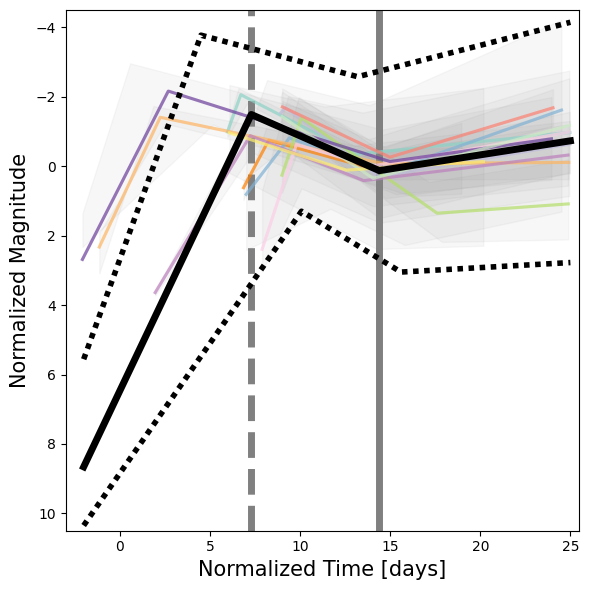

In [207]:
# PLOTTING THE MEAN FIT OVER THE BESTFITS
mean_x = np.arange(-2,25,0.001)

a1s,a2s = [],[]
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
for i,df in enumerate(df_sub_ls):
    df_str =  df_str_list[i]
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

    best = np.array(all_fits_g[i]).T[0] #bestfit values
    lower_bound = np.array(all_fits_g[i]).T[0] - np.array(all_fits_g[i]).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(all_fits_g[i]).T[0] + np.array(all_fits_g[i]).T[2] #50th ptile + diff_84ptile
    a1s.append(best[-3])
    a2s.append(best[-2])
    
    #plotting mcmc results
    plt.plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], alpha=0.7, linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    plt.fill_between(x_plt, lower_curve, upper_curve, color='gray', alpha=0.06)
    
    # #plotting ztf/atlas data
    x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
    # plt.errorbar(x, y, yerr, linestyle='', marker='.', color='black', alpha=0.04, label='data', markersize=15) #ztf errors

#overall mean best fit
mean_fit_g = stats_df[stats_df['filter']=='g']['mean']
lower_mean =  np.array([model(stats_df[stats_df['filter']=='g']['mean']-stats_df[stats_df['filter']=='g']['std'],v,r1=True) for v in mean_x])
upper_mean =  np.array([model(stats_df[stats_df['filter']=='g']['mean']+stats_df[stats_df['filter']=='g']['std'],v,r1=True) for v in mean_x])
plt.plot(mean_x, np.array([model(mean_fit_g, v, r1=True) for v in mean_x]),c='black', label='Mean Best Fit', alpha=1.0, linewidth=5.0)
plt.plot(mean_x, lower_mean, color='black', linestyle=(0,(1,1)), alpha=1.0, linewidth=4.0)
plt.plot(mean_x, upper_mean, color='black', linestyle=(0,(1,1)), alpha=1.0, linewidth=4.0)

mean_a1_g = float(stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean'])
# lower_a1_g, upper_a1_g = stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean']-stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['std'], stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean']+stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['std']
mean_a2_g = float(stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean'])
# lower_a2_g, upper_a2_g = stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean']-stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['std'], stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean']+stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['std']
# plt.axvspan(min_a1, max_a1, alpha=0.03, facecolor='gray', label='a1_range', edgecolor='black', hatch='/', zorder=0)
# plt.axvspan(min_a2, max_a2, alpha=0.03, facecolor='gray', label='a2_range', edgecolor='black', hatch='-', zorder=0)
plt.axvline(mean_a1_g,alpha=1.0, color='gray', linestyle='dashed', linewidth=5, label='Mean a1', zorder=0)
plt.axvline(mean_a2_g,alpha=1.0, color='gray', linestyle='solid', linewidth=5, label='Mean a2', zorder=0)

handles, labels = ax.get_legend_handles_labels()

plt.xlabel('Normalized Time [days]', fontsize=15)
plt.ylabel('Normalized Magnitude', fontsize=15)
# plt.title('MCMC Mean Best Fit for all g-band SNe', fontsize=15)
plt.ylim(10.5,-4.5)
plt.xlim(-3,25.5)
# ax.legend(handles, labels[0:15], loc='center left', bbox_to_anchor=(1, 0.4),frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig(SAVE_DIR+'/figures/mean_mcmc_fits_g.png')

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_86128/446146313.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_a1_r = float(stats_df[stats_df['filter']=='r'].loc[stats_df['param']=='a1']['mean'])
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_86128/446146313.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_a2_r = float(stats_df[stats_df['filter']=='r'].loc[stats_df['param']=='a2']['mean'])


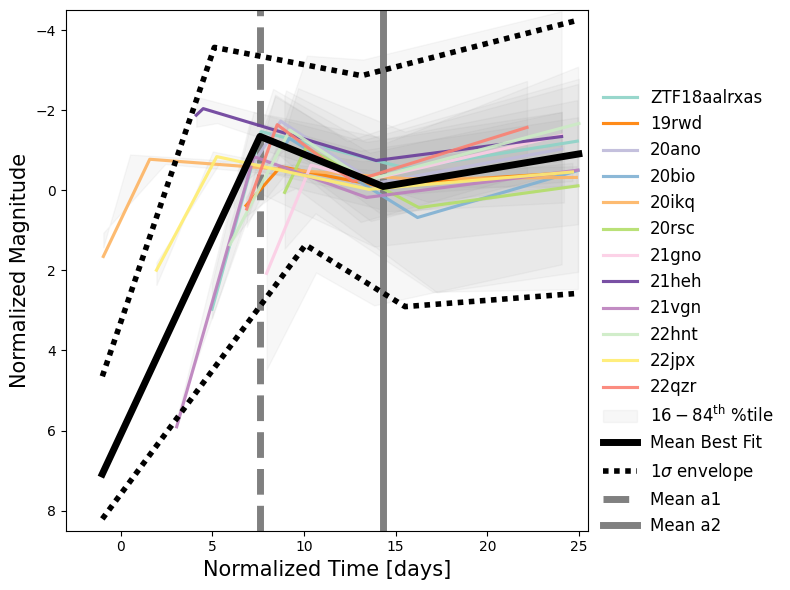

In [208]:
mean_x = np.arange(-1,25,0.01)

a1s,a2s = [],[]
plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
    x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

    best = np.array(all_fits_r[i]).T[0] #bestfit values
    lower_bound = np.array(all_fits_r[i]).T[0] - np.array(all_fits_r[i]).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(all_fits_r[i]).T[0] + np.array(all_fits_r[i]).T[2] #50th ptile + diff_84ptile
    a1s.append(best[-3])
    a2s.append(best[-2])
    
    #plotting mcmc results
    plt.plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], alpha=0.9, linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    plt.fill_between(x_plt, lower_curve, upper_curve, color='gray', alpha=0.06, label='$16-84^{\mathrm{th}}$ %tile')

    #plotting ztf data
    x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
    # plt.errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.05, label='data', markersize=15) #ztf errors, 

#overall mean best fit
mean_fit_r = stats_df[stats_df['filter']=='r']['mean']
lower_mean =  np.array([model(stats_df[stats_df['filter']=='r']['mean']-stats_df[stats_df['filter']=='r']['std'],v,r1=True) for v in mean_x])
upper_mean =  np.array([model(stats_df[stats_df['filter']=='r']['mean']+stats_df[stats_df['filter']=='r']['std'],v,r1=True) for v in mean_x])
plt.plot(mean_x, np.array([model(mean_fit_r, v, r1=True) for v in mean_x]),c='black', label='Mean Best Fit', alpha=1.0, linewidth=5.0)
plt.plot(mean_x, lower_mean, color='black', linestyle=(0,(1,1)), alpha=1.0, linewidth=4)
plt.plot(mean_x, upper_mean, color='black', linestyle=(0,(1,1)), alpha=1.0, linewidth=4, label='$1\sigma$ envelope')

mean_a1_r = float(stats_df[stats_df['filter']=='r'].loc[stats_df['param']=='a1']['mean'])
# lower_a1_g, upper_a1_g = stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean']-stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['std'], stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean']+stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['std']
mean_a2_r = float(stats_df[stats_df['filter']=='r'].loc[stats_df['param']=='a2']['mean'])
# lower_a2_g, upper_a2_g = stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean']-stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['std'], stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean']+stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['std']
# plt.axvspan(min_a1, max_a1, alpha=0.03, facecolor='gray', label='a1_range', edgecolor='black', hatch='/', zorder=0)
# plt.axvspan(min_a2, max_a2, alpha=0.03, facecolor='gray', label='a2_range', edgecolor='black', hatch='-', zorder=0)
plt.axvline(mean_a1_r,alpha=1.0, color='gray', linestyle='dashed', linewidth=5, label='Mean a1', zorder=0)
plt.axvline(mean_a2_r,alpha=1.0, color='gray', linestyle='solid', linewidth=5, label='Mean a2', zorder=0)

plt.xlabel('Normalized Time [days]', fontsize=15)
plt.ylabel('Normalized Magnitude', fontsize=15)
# plt.title('MCMC Mean Best Fit for all r-band SNe', fontsize=15)
plt.ylim(8.5,-4.5)
plt.xlim(-3,25.5)
handles, labels = ax.get_legend_handles_labels()
h, l = handles[:24:2], labels[:24:2]
h2, l2 = handles[23:], labels[23:]
hand, lab = h+h2, l+l2
ax.legend(hand, lab, loc='center left', bbox_to_anchor=(1, 0.42),frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig(SAVE_DIR+'/figures/mean_mcmc_fits_r.png')

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_82255/3113914869.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_g']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_82255/3113914869.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_g']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')


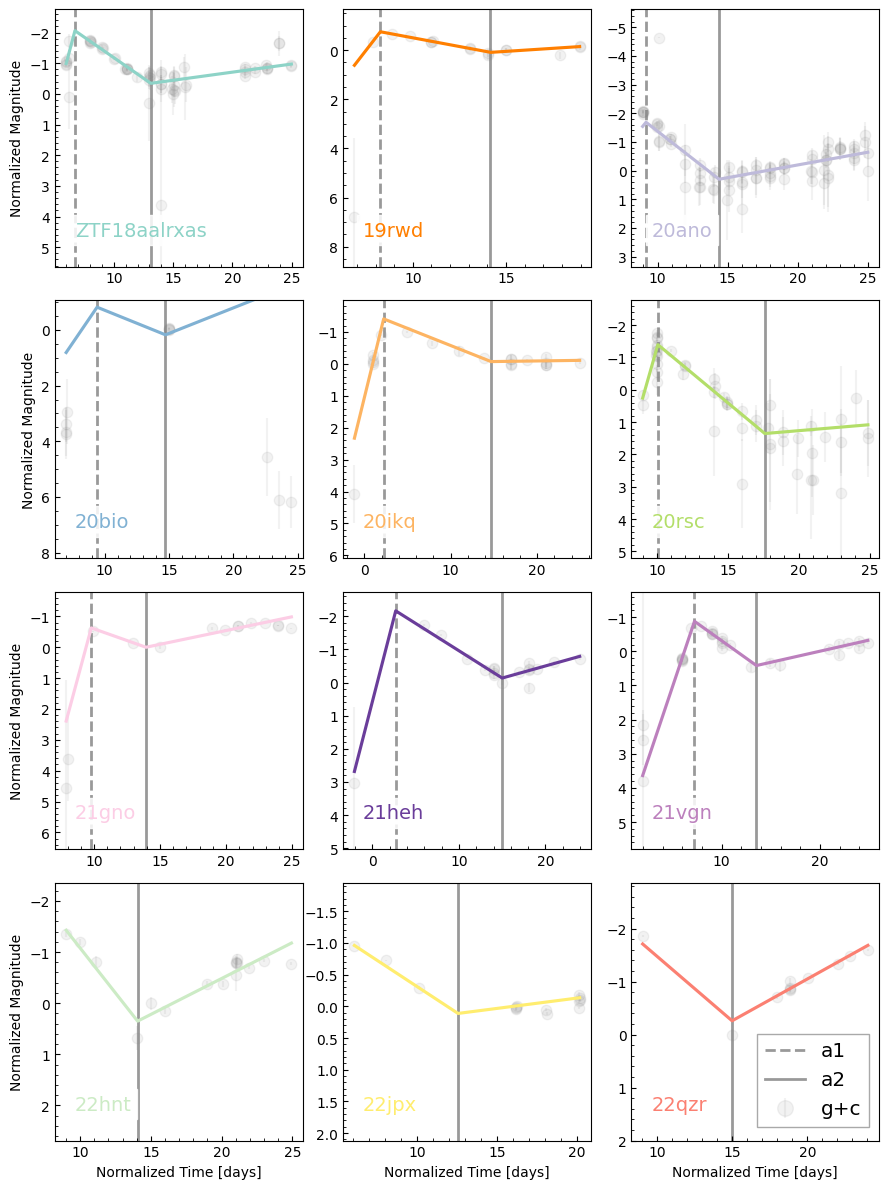

In [332]:
plot_names = ['ZTF18aalrxas', '19rwd', '20ano','20bio','20ikq','20rsc','21gno','21heh','21vgn','22hnt','22jpx','22qzr']

fig, axs = plt.subplots(4,3, figsize=(9,12))
locs = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2]]

for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

    best = np.array(all_fits_g[i]).T[0] #bestfit values
    lower_bound = np.array(all_fits_g[i]).T[0] - np.array(all_fits_g[i]).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(all_fits_g[i]).T[0] + np.array(all_fits_g[i]).T[2] #50th ptile + diff_84ptile
    a1s.append(best[-3])
    a2s.append(best[-2])
    
    #plotting mcmc results
    axs[locs[i][0],locs[i][1]].plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], linewidth=2.25)# linestyle=ls[i])
    axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_g']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
    axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_g']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

    #plotting ztf data
    x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
    axs[locs[i][0],locs[i][1]].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='g+c') #ztf errors,

    bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
    axs[locs[i][0],locs[i][1]].annotate(plot_names[i],xy=(0.08,0.12),xycoords='axes fraction',color=colors[i],fontsize=14, bbox=bbox)

    # axs[locs[i][0],locs[i][1]].set_xlabel('Normalized Time [days]')
    # axs[locs[i][0],locs[i][1]].set_ylabel('Normalized Magnitude')
    axs[locs[i][0],locs[i][1]].set_ylim(max(y)+2, min(y)-1)
    axs[locs[i][0],locs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
    axs[locs[i][0],locs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
    axs[locs[i][0],locs[i][1]].tick_params(which="both",top=False, labeltop=False, bottom=True, labelbottom=True, left=True, right=False, direction="in",zorder=0)

axs[3,0].set_xlabel('Normalized Time [days]')
axs[3,1].set_xlabel('Normalized Time [days]')
axs[3,2].set_xlabel('Normalized Time [days]')

axs[0,0].set_ylabel('Normalized Magnitude')
axs[1,0].set_ylabel('Normalized Magnitude')
axs[2,0].set_ylabel('Normalized Magnitude')
axs[3,0].set_ylabel('Normalized Magnitude')


handles, labels = axs[3,0].get_legend_handles_labels()
fig.legend(handles[1:], labels[1:], loc='center left', bbox_to_anchor=(.835, 0.095),fontsize='x-large',markerscale=1.5,
                frameon=True,fancybox=False,framealpha=1.0,edgecolor='darkgray')
plt.tight_layout()
plt.savefig(SAVE_DIR+'/figures/individ_mcmc_g_fits_subplot.png', dpi=300)

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_82255/3684744158.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_r']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_82255/3684744158.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_r']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')


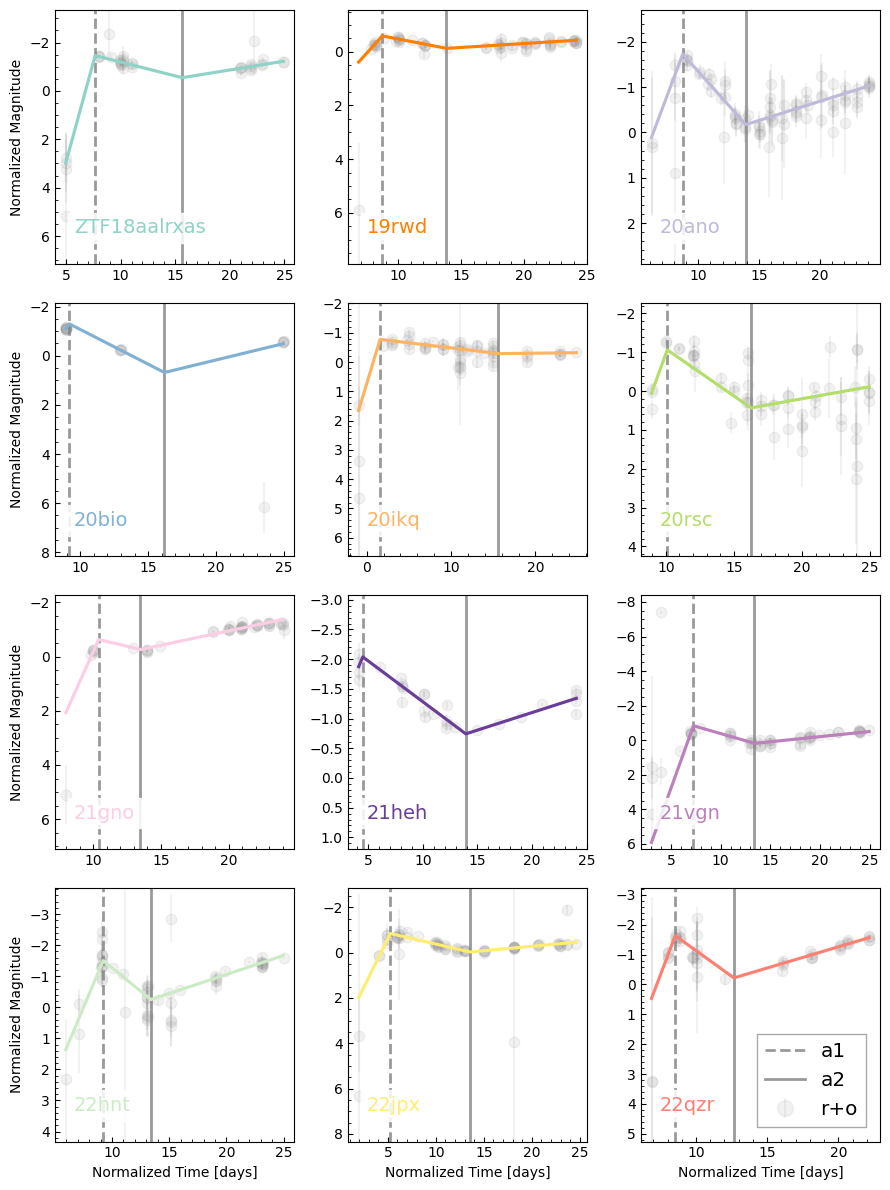

In [334]:
fig, axs = plt.subplots(4,3, figsize=(9,12))
locs = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2]]

for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
    x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

    best = np.array(all_fits_r[i]).T[0] #bestfit values
    lower_bound = np.array(all_fits_r[i]).T[0] - np.array(all_fits_r[i]).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(all_fits_r[i]).T[0] + np.array(all_fits_r[i]).T[2] #50th ptile + diff_84ptile
    a1s.append(best[-3])
    a2s.append(best[-2])
    
    #plotting mcmc results
    axs[locs[i][0],locs[i][1]].plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], linewidth=2.25)# linestyle=ls[i])
    axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_r']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
    axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_r']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

    #plotting ztf data
    x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
    axs[locs[i][0],locs[i][1]].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='r+o') #ztf errors,

    bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
    axs[locs[i][0],locs[i][1]].annotate(plot_names[i],xy=(0.08,0.12),xycoords='axes fraction',color=colors[i],fontsize=14, bbox=bbox)

    # axs[locs[i][0],locs[i][1]].set_xlabel('Normalized Time [days]')
    # axs[locs[i][0],locs[i][1]].set_ylabel('Normalized Magnitude')
    axs[locs[i][0],locs[i][1]].set_ylim(max(y)+2, min(y)-1)
    axs[locs[i][0],locs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
    axs[locs[i][0],locs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
    axs[locs[i][0],locs[i][1]].tick_params(which="both",top=False, labeltop=False, bottom=True, labelbottom=True, left=True, right=False, direction="in",zorder=0)


axs[3,0].set_xlabel('Normalized Time [days]')
axs[3,1].set_xlabel('Normalized Time [days]')
axs[3,2].set_xlabel('Normalized Time [days]')

axs[0,0].set_ylabel('Normalized Magnitude')
axs[1,0].set_ylabel('Normalized Magnitude')
axs[2,0].set_ylabel('Normalized Magnitude')
axs[3,0].set_ylabel('Normalized Magnitude')


handles, labels = axs[3,0].get_legend_handles_labels()
fig.legend(handles[1:], labels[1:], loc='center left', bbox_to_anchor=(.835, 0.095),fontsize='x-large',markerscale=1.5,
                frameon=True,fancybox=False,framealpha=1.0,edgecolor='darkgray')
plt.tight_layout()
plt.savefig(SAVE_DIR+'/figures/individ_mcmc_r_fits_subplot.png', dpi=300)

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_86128/3304389173.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  axs[glocs[i][0],glocs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_g']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_86128/3304389173.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  axs[glocs[i][0],glocs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_g']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_86128/3304389173.py:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) inste

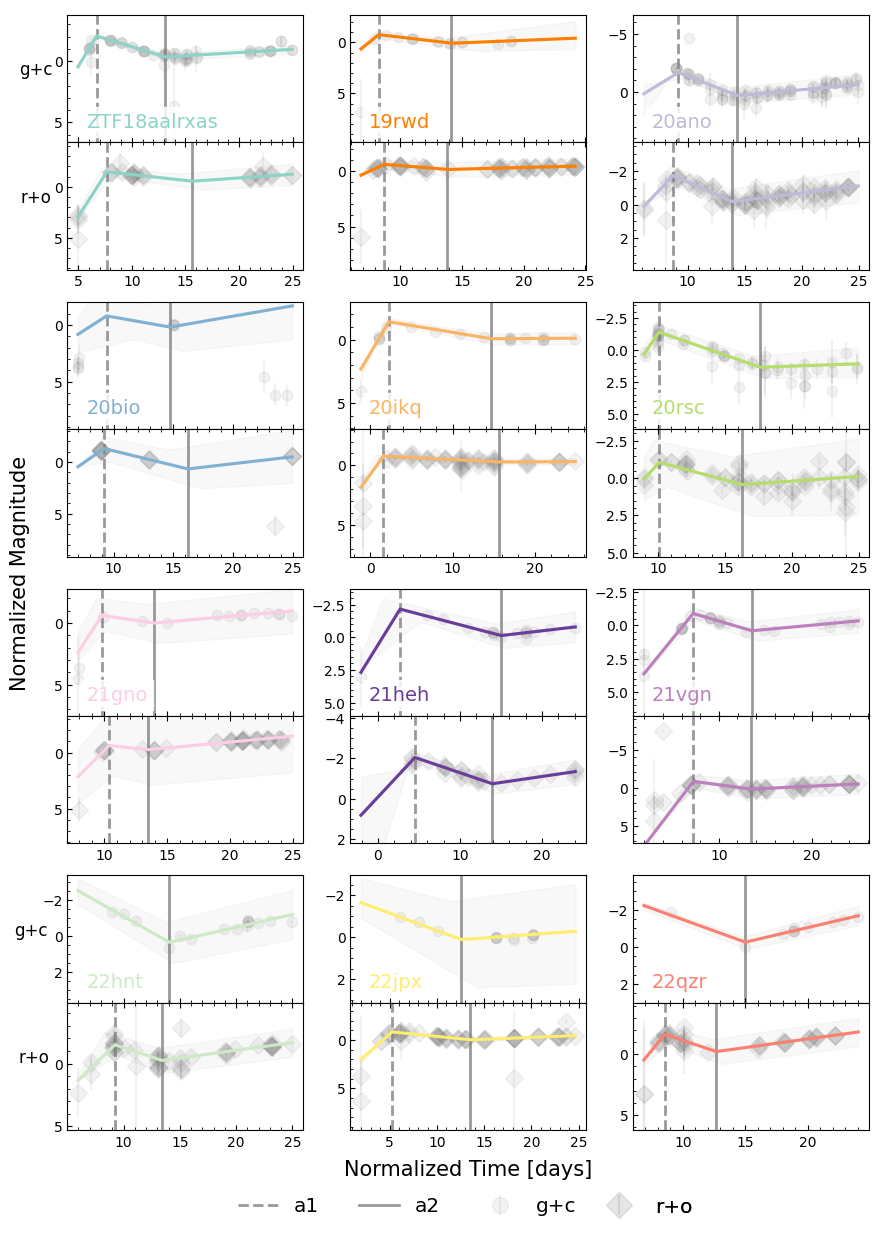

In [144]:
%matplotlib inline
# COMBIINING THE SUBPOTS TO COMPARE B/W G AND R RESULTS
plot_names = ['ZTF18aalrxas', '19rwd', '20ano','20bio','20ikq','20rsc','21gno','21heh','21vgn','22hnt','22jpx','22qzr']

gridspec = dict(hspace=0.0, wspace=0.2, height_ratios=[1,1,0.25,1,1,0.25,1,1,0.25,1,1])
fig, axs = plt.subplots(11,3, figsize=(9,12), sharex=False, gridspec_kw=gridspec)
glocs = [[0,0],[0,1],[0,2],[3,0],[3,1],[3,2],[6,0],[6,1],[6,2],[9,0],[9,1],[9,2]]
rlocs = [[1,0],[1,1],[1,2],[4,0],[4,1],[4,2],[7,0],[7,1],[7,2],[10,0],[10,1],[10,2]]
elocs = [[2,0],[2,1],[2,2],[5,0],[5,1],[5,2],[8,0],[8,1],[8,2]]

for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]

    x_plt = np.arange(min(list(g_df['norm_t'])+list(r_df['norm_t'])),max(list(g_df['norm_t'])+list(r_df['norm_t'])),0.01)

    ################## g band
    best = np.array(all_fits_g[i]).T[0] #bestfit values
    lower_bound = np.array(all_fits_g[i]).T[0] - np.array(all_fits_g[i]).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(all_fits_g[i]).T[0] + np.array(all_fits_g[i]).T[2] #50th ptile + diff_84ptile
    
    #plotting mcmc results
    axs[glocs[i][0],glocs[i][1]].plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    axs[glocs[i][0],glocs[i][1]].fill_between(x_plt, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)
    axs[glocs[i][0],glocs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_g']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
    axs[glocs[i][0],glocs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_g']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

    #plotting ztf data
    x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
    axs[glocs[i][0],glocs[i][1]].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='g+c') #ztf errors,

    axs[glocs[i][0],glocs[i][1]].set_ylim(max(y)+3, min(y)-2)
    axs[glocs[i][0],glocs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
    axs[glocs[i][0],glocs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
    axs[glocs[i][0],glocs[i][1]].tick_params(which="both",top=False, labeltop=False, bottom=True, labelbottom=False, left=True, right=False, direction="in",zorder=0)

    ################## r band
    best_r = np.array(all_fits_r[i]).T[0] #bestfit values
    lower_bound_r = np.array(all_fits_r[i]).T[0] - np.array(all_fits_r[i]).T[1] #50th ptile - diff_16ptile
    upper_bound_r = np.array(all_fits_r[i]).T[0] + np.array(all_fits_r[i]).T[2] #50th ptile + diff_84ptile
    
    #plotting mcmc results
    axs[rlocs[i][0],rlocs[i][1]].plot(x_plt, np.array([model(best_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], linewidth=2.25)# linestyle=ls[i])
    lower_curve_r = np.array([model(lower_bound_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    upper_curve_r = np.array([model(upper_bound_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    axs[rlocs[i][0],rlocs[i][1]].fill_between(x_plt, lower_curve_r, upper_curve_r, color='gray', alpha=0.05, zorder=0)
    axs[rlocs[i][0],rlocs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_r']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
    axs[rlocs[i][0],rlocs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_r']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

    #plotting ztf data
    xr,yr,yerrr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
    axs[rlocs[i][0],rlocs[i][1]].errorbar(xr, yr, yerrr, linestyle='', marker='D', color='gray', alpha=0.1, markersize=9, zorder=0, label='r+o') #ztf errors,

    axs[rlocs[i][0],rlocs[i][1]].set_ylim(max(yr)+3, min(yr)-2)
    axs[rlocs[i][0],rlocs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
    axs[rlocs[i][0],rlocs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
    axs[rlocs[i][0],rlocs[i][1]].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=False, direction="in",zorder=0)

    ########## labels
    bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
    axs[glocs[i][0],glocs[i][1]].annotate(plot_names[i],xy=(0.08,0.12),xycoords='axes fraction',color=colors[i],fontsize=14, bbox=bbox)

for i,e in enumerate(elocs):
    axs[e[0],e[1]].set_visible(False)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Normalized Time [days]", fontsize=15)
plt.ylabel("Normalized Magnitude", fontsize=15)
axs[0,0].set_ylabel('g+c', rotation=0, labelpad=13, fontsize=12)
axs[1,0].set_ylabel("r+o", rotation=0, labelpad=13, fontsize=12)
axs[9,0].set_ylabel('g+c', rotation=0, labelpad=8, fontsize=12)
axs[10,0].set_ylabel("r+o", rotation=0, labelpad=14, fontsize=12)


handles, labels = axs[9,2].get_legend_handles_labels()
fig.legend(handles[1:], labels[1:], loc='center left', bbox_to_anchor=(.25, -0.01),fontsize='x-large',markerscale=1.5,
                frameon=False,fancybox=False,ncols=3)

h1, l1 = axs[10,2].get_legend_handles_labels()
h, l = h1[3:], l1[3:]
leg1 = axs[10,2].legend(h, l, loc='center left', bbox_to_anchor=(-0.22, -0.6),fontsize='x-large',markerscale=1.5,
                frameon=False,fancybox=False,)
axs[10,2].add_artist(leg1)

plt.tight_layout()
plt.savefig(SAVE_DIR+'/figures/individ_mcmc_fits_subplot_both_bands.png', dpi=300)

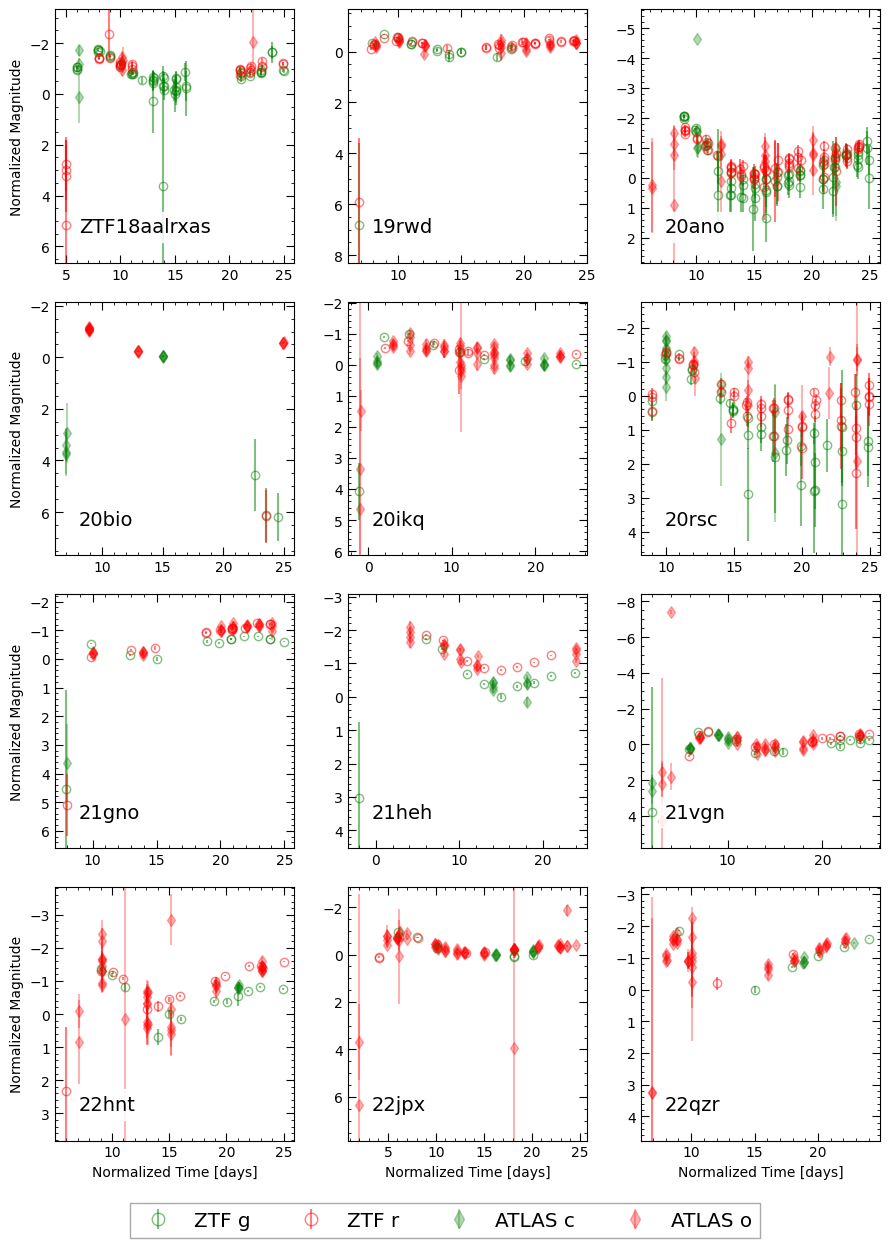

In [380]:
fig, axs = plt.subplots(4,3, figsize=(9,12))
locs = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2]]

for i,df in enumerate(df_sub_ls):
    axs[locs[i][0],locs[i][1]].errorbar(df[df['filter']=='ZTF_g']['norm_t'], df[df['filter']=='ZTF_g']['norm_m'],df[df['filter']=='ZTF_g']['mag_err_all'],
                 markeredgecolor='green',markerfacecolor='none',ecolor='green',label='ZTF g',alpha=0.5,linestyle='',marker='o')
    axs[locs[i][0],locs[i][1]].errorbar(df[df['filter']=='ZTF_r']['norm_t'], df[df['filter']=='ZTF_r']['norm_m'],df[df['filter']=='ZTF_r']['mag_err_all'],
                 markeredgecolor='red',markerfacecolor='none',ecolor='red',label='ZTF r',alpha=0.5,linestyle='',marker='o')
    axs[locs[i][0],locs[i][1]].errorbar(df[df['filter']=='c']['norm_t'], df[df['filter']=='c']['norm_m'],df[df['filter']=='c']['mag_err_all'],
                 color='green', marker='d',label='ATLAS c',alpha=0.3,linestyle='',zorder=0)
    axs[locs[i][0],locs[i][1]].errorbar(df[df['filter']=='o']['norm_t'], df[df['filter']=='o']['norm_m'],df[df['filter']=='o']['mag_err_all'],
                 color='red', marker='d', label='ATLAS o',alpha=0.3,linestyle='',zorder=0)
    
    y_mins = [df[df['filter']=='ZTF_g']['norm_m'].min(), df[df['filter']=='ZTF_r']['norm_m'].min(), df[df['filter']=='c']['norm_m'].min(), df[df['filter']=='o']['norm_m'].min()]
    y_maxs = [df[df['filter']=='ZTF_g']['norm_m'].max(), df[df['filter']=='ZTF_r']['norm_m'].max(), df[df['filter']=='c']['norm_m'].max(), df[df['filter']=='o']['norm_m'].max()]
    
    axs[locs[i][0],locs[i][1]].set_ylim(max(y_maxs)+1.5, min(y_mins)-1)
    axs[locs[i][0],locs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
    axs[locs[i][0],locs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
    axs[locs[i][0],locs[i][1]].tick_params(which="both", top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in")
    axs[locs[i][0],locs[i][1]].xaxis.set_tick_params(length=6)
    axs[locs[i][0],locs[i][1]].yaxis.set_tick_params(length=6)
    
    bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
    axs[locs[i][0],locs[i][1]].annotate(plot_names[i],xy=(0.1,0.12),xycoords='axes fraction',color='k',fontsize=14,bbox=bbox)

axs[3,0].set_xlabel('Normalized Time [days]')
axs[3,1].set_xlabel('Normalized Time [days]')
axs[3,2].set_xlabel('Normalized Time [days]')

axs[0,0].set_ylabel('Normalized Magnitude')
axs[1,0].set_ylabel('Normalized Magnitude')
axs[2,0].set_ylabel('Normalized Magnitude')
axs[3,0].set_ylabel('Normalized Magnitude')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[0:4], labels[0:4], loc='lower center', bbox_to_anchor=(0.5, -0.045), ncol=4, fontsize='x-large',markerscale=1.5,
                frameon=True,fancybox=False,framealpha=1.0,edgecolor='darkgray')
fig.tight_layout()
plt.savefig(SAVE_DIR+'/figures/individ_fp_lcs_subplot.png',dpi=300)